<a href="https://colab.research.google.com/github/nnajeh/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 35

# Learning rate for optimizers
#change learning rate from lr = 0.0002
#lr_G = 0.0002
#lr_D = 0.0002
#lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
train = 'C:/Users/nafti/OneDrive/Bureau/Conda/data/Normal/'

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_train = dset.ImageFolder(root=train,
                               transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [ ]:
# Create the dataloader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

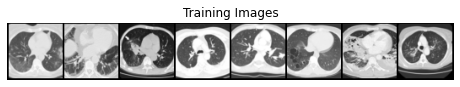

In [ ]:
#Visualize train data

# Plot some training images
real_batch = next(iter(dataloader_train))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# Weight initialization

In [ ]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Model

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
# Create the generator
netG = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
#Discriminator Code

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.002, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.002, betas=(beta1, 0.999))

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

iters = 0
num_epochs = 35

In [ ]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
from torchvision.utils import save_image

In [ ]:
#Display generated data 
def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

In [ ]:
print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_train, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
       
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        
        # Output training stats and Save trained model
        if i % 100 == 0:
            print('[%d/%d]\tLoss_D:%.4f\tLoss_G:%.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, ))
            
            torch.save(netG.state_dict(),'./saved_model/generator.pth')
            torch.save(netD.state_dict(),'./saved_model/discriminator.pth')
            

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
 
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_train)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        #Save Fake and real images in folders    
        if i % 100 == 0:
            vutils.save_image(real_cpu,'%s/real_samples.png' % './real_images_train', normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), '%s/fake_samples_epoch_%03d.png' %('./fake_images_train', epoch), normalize=True)

        iters += 1
    
    #image_check(fake.cpu())
    
   # torch.save(netG.state_dict(), './Anomaly_detection/G_epoch{}.pt'.format(epoch))
   # torch.save(netD.state_dict(), './Anomaly_detection/D_epoch{}.pt'.format(epoch))


Starting Training Loop...
[0/35]	Loss_D:1.4074	Loss_G:54.2294	D(x): 0.7178	D(G(z)): 0.6270 / 0.0000
[1/35]	Loss_D:2.4520	Loss_G:2.4115	D(x): 0.2953	D(G(z)): 0.2141 / 0.1822
[2/35]	Loss_D:1.0873	Loss_G:7.6308	D(x): 0.9808	D(G(z)): 0.2907 / 0.1863
[3/35]	Loss_D:3.9483	Loss_G:2.0248	D(x): 0.4380	D(G(z)): 0.5475 / 0.3752
[4/35]	Loss_D:1.6765	Loss_G:5.3051	D(x): 0.8456	D(G(z)): 0.6220 / 0.0069
[5/35]	Loss_D:0.6047	Loss_G:5.7563	D(x): 0.9509	D(G(z)): 0.3601 / 0.0058
[6/35]	Loss_D:1.6495	Loss_G:4.9494	D(x): 0.8573	D(G(z)): 0.4612 / 0.0288
[7/35]	Loss_D:1.3594	Loss_G:7.5304	D(x): 0.7418	D(G(z)): 0.5384 / 0.0019
[8/35]	Loss_D:1.2971	Loss_G:5.5100	D(x): 0.7901	D(G(z)): 0.3325 / 0.0170
[9/35]	Loss_D:2.3274	Loss_G:4.3969	D(x): 0.9173	D(G(z)): 0.7447 / 0.0272
[10/35]	Loss_D:0.6699	Loss_G:4.2609	D(x): 0.9383	D(G(z)): 0.3868 / 0.0253
[11/35]	Loss_D:1.5917	Loss_G:5.2541	D(x): 0.6942	D(G(z)): 0.5785 / 0.0138
[12/35]	Loss_D:0.7716	Loss_G:2.8137	D(x): 0.9587	D(G(z)): 0.4697 / 0.0881
[13/35]	Loss_D:1.6045

# Loss Visualization

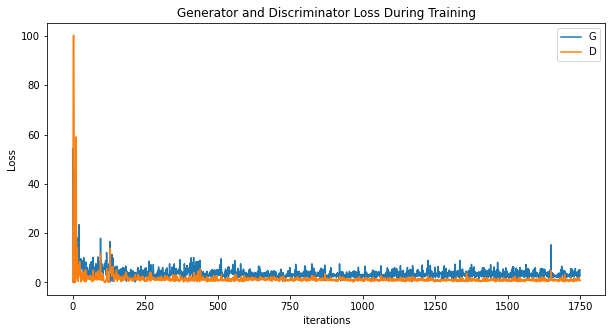

In [ ]:
#Results: Finally, lets check out how we did.
# Below is a plot of D & G’s losses versus training iterations.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss.png')
plt.show()

C:\Users\nafti\anaconda3\envs\st\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nafti\anaconda3\envs\st\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


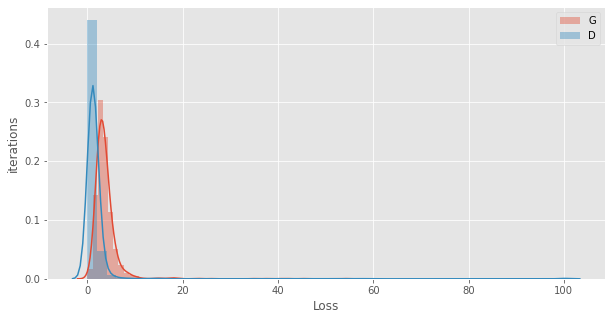

In [ ]:
#Generator and discriminator loss over time
import seaborn as sns

plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
sns.distplot(G_losses, hist=True, label='G')
sns.distplot(D_losses, hist=True, label='D')
plt.xlabel("Loss")
plt.ylabel("iterations")
plt.legend()